# Kaggle Competition - House Price Prediction
Sissie Cui, Jeffrey Day, Melinda Leung, and Rochelle Li

## 1. Import packages

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.lines import Line2D
from scipy import stats
import math
from statsmodels.stats.outliers_influence import variance_inflation_factor
from sklearn.preprocessing import StandardScaler

## 2. Load and inspect data

The data can be found here: [House Prices - Advanced Regression Techniques](https://www.kaggle.com/c/house-prices-advanced-regression-techniques).

In [2]:
train_df = pd.read_csv('data/train.csv')
test_df = pd.read_csv('data/test.csv')
test_ids = test_df['Id']

# Check for duplicates
print('Number of duplicate(s): %d\n' %train_df.duplicated().sum())

print('Training data shape:', train_df.shape)
print('Test data shape:', test_df.shape)

Number of duplicate(s): 0

Training data shape: (1460, 81)
Test data shape: (1459, 80)


From initial inspection, the test data has one more column than the train data, what is it?

In [3]:
#columns of train and test data
train_col = train_df.columns
test_col = test_df.columns

# Which feature is in train data but not test data?
diff_feat = np.setdiff1d(train_col, test_col)
print('Feature in train data but not test data:', diff_feat, '\n')

result = all(feature in train_col for feature in test_col)
if result:
    print('All features in test data are also features in training data')
else:
    print('Not all features in test data are also features in training data')

Feature in train data but not test data: ['SalePrice'] 

All features in test data are also features in training data


The only variable not in the test data that is in the train data is the dependent variable for this project `SalePrice` which makes sense.

Next get an idea of what the columns are, and what their values look like.

In [4]:
pd.set_option("display.max.columns", None)
train_df.head()

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,LandSlope,Neighborhood,Condition1,Condition2,BldgType,HouseStyle,OverallQual,OverallCond,YearBuilt,YearRemodAdd,RoofStyle,RoofMatl,Exterior1st,Exterior2nd,MasVnrType,MasVnrArea,ExterQual,ExterCond,Foundation,BsmtQual,BsmtCond,BsmtExposure,BsmtFinType1,BsmtFinSF1,BsmtFinType2,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,Heating,HeatingQC,CentralAir,Electrical,1stFlrSF,2ndFlrSF,LowQualFinSF,GrLivArea,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,KitchenQual,TotRmsAbvGrd,Functional,Fireplaces,FireplaceQu,GarageType,GarageYrBlt,GarageFinish,GarageCars,GarageArea,GarageQual,GarageCond,PavedDrive,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,Inside,Gtl,CollgCr,Norm,Norm,1Fam,2Story,7,5,2003,2003,Gable,CompShg,VinylSd,VinylSd,BrkFace,196.0,Gd,TA,PConc,Gd,TA,No,GLQ,706,Unf,0,150,856,GasA,Ex,Y,SBrkr,856,854,0,1710,1,0,2,1,3,1,Gd,8,Typ,0,NaN,Attchd,2003.0,RFn,2,548,TA,TA,Y,0,61,0,0,0,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
1,2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,FR2,Gtl,Veenker,Feedr,Norm,1Fam,1Story,6,8,1976,1976,Gable,CompShg,MetalSd,MetalSd,None,0.0,TA,TA,CBlock,Gd,TA,Gd,ALQ,978,Unf,0,284,1262,GasA,Ex,Y,SBrkr,1262,0,0,1262,0,1,2,0,3,1,TA,6,Typ,1,TA,Attchd,1976.0,RFn,2,460,TA,TA,Y,298,0,0,0,0,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
2,3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,Inside,Gtl,CollgCr,Norm,Norm,1Fam,2Story,7,5,2001,2002,Gable,CompShg,VinylSd,VinylSd,BrkFace,162.0,Gd,TA,PConc,Gd,TA,Mn,GLQ,486,Unf,0,434,920,GasA,Ex,Y,SBrkr,920,866,0,1786,1,0,2,1,3,1,Gd,6,Typ,1,TA,Attchd,2001.0,RFn,2,608,TA,TA,Y,0,42,0,0,0,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
3,4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,Corner,Gtl,Crawfor,Norm,Norm,1Fam,2Story,7,5,1915,1970,Gable,CompShg,Wd Sdng,Wd Shng,None,0.0,TA,TA,BrkTil,TA,Gd,No,ALQ,216,Unf,0,540,756,GasA,Gd,Y,SBrkr,961,756,0,1717,1,0,1,0,3,1,Gd,7,Typ,1,Gd,Detchd,1998.0,Unf,3,642,TA,TA,Y,0,35,272,0,0,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
4,5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,FR2,Gtl,NoRidge,Norm,Norm,1Fam,2Story,8,5,2000,2000,Gable,CompShg,VinylSd,VinylSd,BrkFace,350.0,Gd,TA,PConc,Gd,TA,Av,GLQ,655,Unf,0,490,1145,GasA,Ex,Y,SBrkr,1145,1053,0,2198,1,0,2,1,4,1,Gd,9,Typ,1,TA,Attchd,2000.0,RFn,3,836,TA,TA,Y,192,84,0,0,0,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000


This dataset has 79 (excluding Id) different variables. 46 are categorical, 28 are numeric and 5 are date variables. Because there are so many different features, we will spend a bulk of our time understanding which columns can be removed or transformed.

## 3. `SalePrice` variable exploration

We are interested in predicting the SalePrice, which is the property's sale price in dollars. It is a continuous variable, with a median of 163K and a mean of 181K. The lowest sales price is 34.9K and the largest sales price is 755K. Let's plot this variable:

Text(0.5, 1.0, 'SalePrice Histogram')

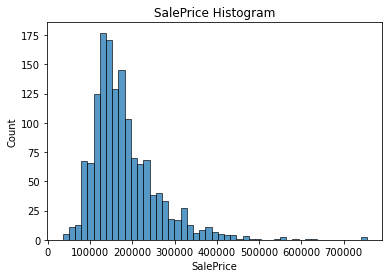

In [5]:
sns.histplot(train_df['SalePrice']).set_title('SalePrice Histogram')

The distribution does not look normal, check for skew and kurtosis.

In [6]:
print('Skewness:', train_df['SalePrice'].skew())
print('Kurtosis:', train_df['SalePrice'].kurtosis())

Skewness: 1.8828757597682129
Kurtosis: 6.536281860064529


The skewness and kurtosis values imply that some sort of transformation on the `SalePrice` variable will be required. Examine how a log transformation affects the skew and kurtosis.

Text(0.5, 0, 'Log of SalePrice')

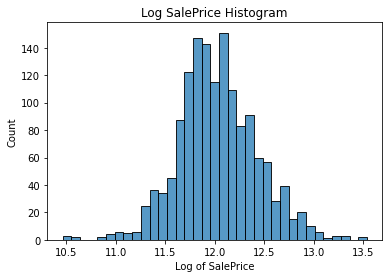

In [7]:
ax = sns.histplot(np.log(train_df['SalePrice']))
ax.set_title('Log SalePrice Histogram')
plt.xlabel('Log of SalePrice')

In [8]:
print('Skewness:', np.log(train_df['SalePrice']).skew())
print('Kurtosis:', np.log(train_df['SalePrice']).kurtosis())

Skewness: 0.12133506220520406
Kurtosis: 0.8095319958036296


Taking the log of the Sales Price improved the skew and kurtosis. We will add use this transformation for our dataset.

In [9]:
train_df['log_SalePrice'] = np.log(train_df['SalePrice'])

## 4. Handling missing and erroneous values

First, lets get a sense of which columns have a number of missing values for both the test and train data.

In [10]:
def nulls_check(data):
    nulls_total = data.isnull().sum().sort_values(ascending=False)
    nulls_prop = (100 * data.isnull().sum()/1460).round(1).sort_values(ascending=False)
    nulls_table = pd.concat([nulls_total, nulls_prop], axis=1, keys=['Total No. of Missing Values', '% of Total'])
    nulls_sum = nulls_table[nulls_table['Total No. of Missing Values'] > 0]
    return display(nulls_sum)

nulls_check(train_df)

,Total No. of Missing Values,% of Total
PoolQC,1453,99.5
MiscFeature,1406,96.3
Alley,1369,93.8
Fence,1179,80.8
FireplaceQu,690,47.3
LotFrontage,259,17.7
GarageType,81,5.5
GarageYrBlt,81,5.5
GarageCond,81,5.5
GarageQual,81,5.5


In [11]:
nulls_check(test_df)

,Total No. of Missing Values,% of Total
PoolQC,1456,99.7
MiscFeature,1408,96.4
Alley,1352,92.6
Fence,1169,80.1
FireplaceQu,730,50.0
LotFrontage,227,15.5
GarageYrBlt,78,5.3
GarageQual,78,5.3
GarageFinish,78,5.3
GarageCond,78,5.3


For both the train and test data sets, `Fence`, `PoolQC`, `MiscFeature`, and `Alley` all have missing value percentages over 80%. Because a significant amount of these values are missing, they most likely will not be helpful for modeling so remove them from consideration in the data set. A summary of how we treat the data:

* If more than 80% of the values are missing, we will disregard the variable.
* If the variable is categorical:
    * If “NA” has intended meaning, such as “no garage”，“no basement”, then replace the missing values with “NONE”. If “NA” is an existing category, we will ensure consistency and differentiate between NA and None.
    * Variables with NA that have meaning include Alley, BsmtQual, BsmtCond, BsmtExposure, BsmtFinType1, BsmtFinType2, FireplaceQu, GarageType, GarageFinish, GarageQual, GarageCond, PoolQC, Fence, MiscFeature
Otherwise, replace with mode.
* If the variable is numerical:
    * If “NA” refers to “0", such as “Lotfrontage”, replace the missing value with 0.
    * Otherwise, replace it with median.

Next, define a function to handle missing values based on documentation provided in the Kaggle project, and descriptions of each of the variables.

In [12]:
# features with 'NA' as a valid entry
na_col = ['BsmtQual', 'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinType2', 'FireplaceQu', 
          'GarageType', 'GarageFinish', 'GarageQual', 'GarageCond']

def col_miss_replace(df, feature, check_feature):
    feature_mask = df[feature].isna()
    true_mask = df[check_feature].isin(['None'])

    false_mask = np.invert(true_mask)
    df[feature] = df[feature].mask(feature_mask & true_mask, 0)
    df[feature] = df[feature].mask(feature_mask & false_mask, df[feature].median())
    
def missing_val_treat(df, del_ind):
    # deletes features in del_ind
    df.drop(del_ind, axis=1, inplace=True)
    
    # replace missing values with 'None' for features with 'NA' as valid entry
    df[na_col] = df[na_col].fillna('None')
    
    # features with missing vals that will take mode
    mode_col = ['MSSubClass', 'MSZoning', 'Street', 'LotShape', 'LandContour', 'Utilities', 
                    'LotConfig', 'LandSlope', 'Neighborhood', 'Condition1', 'Condition2', 'BldgType', 
                    'HouseStyle', 'OverallQual', 'OverallCond', 'RoofStyle', 'RoofMatl', 'Exterior1st', 
                    'Exterior2nd', 'MasVnrType', 'ExterQual', 'ExterCond', 'Foundation', 'Heating', 
                    'HeatingQC', 'CentralAir', 'Electrical', 'KitchenQual', 'Functional', 'PavedDrive', 
                    'MoSold', 'YrSold', 'SaleType', 'SaleCondition', 'YearBuilt']
    
    # features with missings that will take median
    med_col = ['LotFrontage', 'LotArea', '1stFlrSF', '2ndFlrSF', 'LowQualFinSF', 'GrLivArea', 
                       'FullBath', 'HalfBath', 'BedroomAbvGr', 'KitchenAbvGr', 'TotRmsAbvGrd', 
                       'WoodDeckSF', 'OpenPorchSF', 'EnclosedPorch', '3SsnPorch', 'ScreenPorch', 
                       'PoolArea', 'MiscVal']
    
    for col in mode_col:
        df[col].fillna(df[col].mode()[0], inplace=True)
        
    df[med_col] = df[med_col].fillna(df[med_col].median())
    
    bsmt_col = ['BsmtFinSF1', 'BsmtFinSF2', 'BsmtUnfSF', 'TotalBsmtSF', 'BsmtFullBath', 'BsmtHalfBath']
    for col in bsmt_col:
        col_miss_replace(df, col, 'BsmtQual')
    
    col_miss_replace(df, 'MasVnrArea', 'MasVnrType')
    col_miss_replace(df, 'GarageCars', 'GarageCond')
    col_miss_replace(df, 'GarageArea', 'GarageCond')
    col_miss_replace(df, 'Fireplaces', 'FireplaceQu')
    
    df.loc[df['GarageYrBlt'] == 'None', 'YearBuilt'] = df['YearBuilt'].mode()[0]
    
    df['YearRemodAdd'].fillna(df['YearBuilt'], inplace=True)
    
    #what to fill garage year if no garage?
    df.loc[df['GarageCond'] == 'None', 'GarageYrBlt'] = df['YearBuilt']

Apply the above function to the test and training df.

In [13]:
nulls_prop = pd.concat([train_df.isnull().sum()/1460], axis=1, keys=['Percent'])
del_ind = (nulls_prop[nulls_prop['Percent'] > 0.8]).index
missing_val_treat(train_df, del_ind)
missing_val_treat(test_df, del_ind)

In [14]:
nulls_check(train_df)

,Total No. of Missing Values,% of Total


In [15]:
nulls_check(test_df)

,Total No. of Missing Values,% of Total


## 5. Handling Outliers

Outliers will be handled using 3 approaches:

1. Author Recommendations - According to the Ames paper, the author recommends removing any houses with more than 4000 square feet.
2. Removing Outliers for Top Variables - We will look at the correlation between the variables and remove outliers for the top 3 variables. Outliers will be defined as any value lying more than 3 standard deviations away from the mean.
3. Understanding Skew & Kurtossis - Looking at skew and kurtosis for all numeric variables, we will also consider whether or not it makes sense to apply a transformation or simply just remove the outliers.

#### 1. Author Recommendations

In [16]:
train_df = train_df[train_df.GrLivArea <= 4000]
train_df.shape

(1456, 78)

This removes 4 entries from the training set.

#### 2. Removing Outliers for Top Variables

Next, lets look at correlations between variables and remove outliers for the top 3.

<AxesSubplot:>

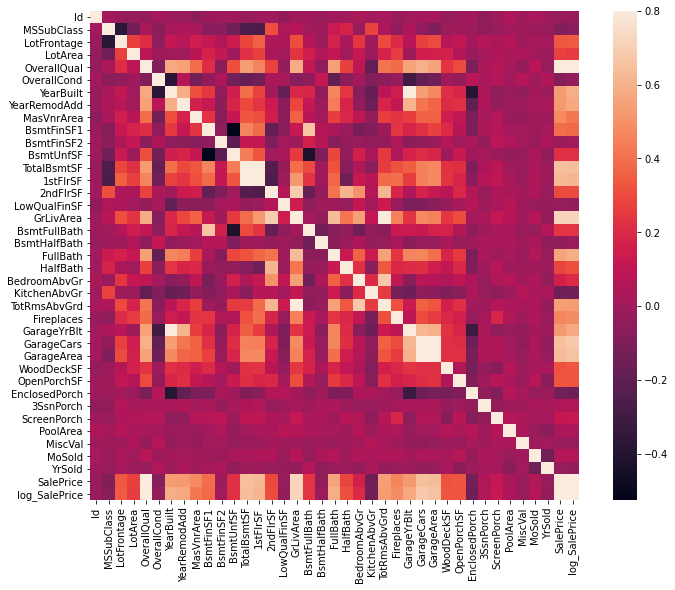

In [17]:
# correlation matrix
corrmat = train_df.corr()
f, ax = plt.subplots(figsize=(12, 9))
sns.heatmap(corrmat, vmax=.8, square=True)

In [18]:
# absolute value of correlations
abs_corr_log = train_df.corr()['log_SalePrice'].abs().sort_values(ascending=False)
print('Features greatest absolute values of correlations w/ log_Saleprice:\n', abs_corr_log.head(6))

Features greatest absolute values of correlations w/ log_Saleprice:
 log_SalePrice    1.000000
SalePrice        0.954609
OverallQual      0.819240
GrLivArea        0.718844
GarageCars       0.680408
GarageArea       0.655211
Name: log_SalePrice, dtype: float64


In [19]:
abs_corr = train_df.corr()['SalePrice'].abs().sort_values(ascending=False)
print('Features greatest absolute values of correlations w/ Saleprice:\n', abs_corr.head(6))

Features greatest absolute values of correlations w/ Saleprice:
 SalePrice        1.000000
log_SalePrice    0.954609
OverallQual      0.800858
GrLivArea        0.720516
GarageCars       0.649256
TotalBsmtSF      0.646584
Name: SalePrice, dtype: float64


Quick sanity check: highest correlating feature of SalePrice is itself and the same for log_SalePrice. We will revisit the correlation matrix in the feature engineering section.

Top three variables with correlations to log sale price and sale price are `OverallQual`, `GrLivArea`, and `GarageCars`. Below, remove outliers outside from the three columns.

In [20]:
high_corr_features = ['OverallQual', 'GrLivArea', 'GarageCars'] 
Q1 = train_df[high_corr_features].quantile(0.25)
Q3 = train_df[high_corr_features].quantile(0.75)
IQR = Q3 - Q1
train_df_encoded = train_df[~((train_df[high_corr_features] < (Q1 - 1.5 * IQR)) 
                                    |(train_df[high_corr_features] > (Q3 + 1.5 * IQR))).any(axis=1)]

print('Total Number of Outliers Removed:', (len(train_df) - len(train_df_encoded)))

Total Number of Outliers Removed: 34


## 6. Further EDA

From our correlation plot above, we saw that the most highly correlated variables seem to be `OverallQual`, `GrLivArea`, and `GarageCars`. We will take a quick look at these variables.

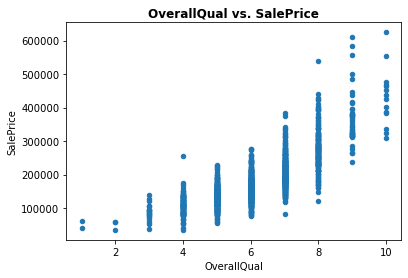

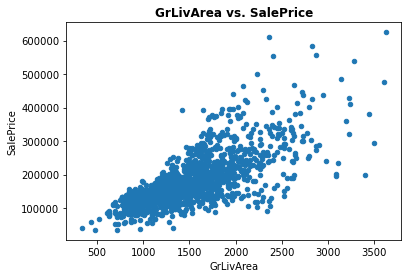

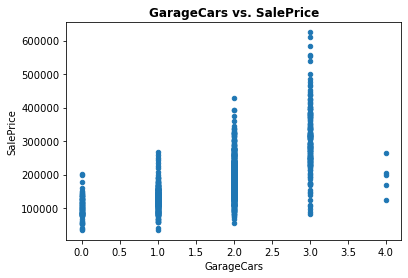

In [21]:
top_features = ['OverallQual', 'GrLivArea', 'GarageCars']
for col in top_features:
    train_df.plot(col, 'SalePrice', kind='scatter')
    plt.title(f'{col} vs. SalePrice', fontweight = 'bold')

Each of these variables have a positive correlation with the sale price and it is not surprising that they were also most highly correlated with Sales Price.
- When selling a house, the overall quality of the material and finish of the house, has a strong influence on the selling price.
- GrLivArea, or the size in square feet of the ground floor, is also very telling. This aligns with our assumption that the larger the house, the steeper the price.
- Lastly, GarageCars, which indicates the number of cars the garage can hold, is also strongly correlated with the price of the house.

## 7. Feature Engineering

For feature engineering, we will:
1. Understand the Skew & Kurtosis - Looking at skew and kurtosis for all numeric variables, we will also consider whether or not it makes sense to apply a transformation or simply just remove the outliers.
2. Introduce new variables - There are multiple variables regarding the size of the home. One way to reduce the number of columns is to sum up all these variables.
3. Remove variables - Remove any variables with low variance, low correlation with `SalePrice` or are redundant.

#### 1. Understand the Skew & Kurtosis

Evaluate the skew & kurtosis of numeric variables.

In [22]:
numerics = ['int16', 'int32', 'int64', 'float16', 'float32', 'float64']
numeric_variables = train_df.select_dtypes(include=numerics)

num_var_desc = train_df[numeric_variables.columns.values].describe().T
num_var_desc['Skew'] = train_df[numeric_variables.columns.values].skew()
num_var_desc['Kurtosis'] = train_df[numeric_variables.columns.values].kurt()
num_var_desc = num_var_desc.rename_axis('Column').reset_index()

large_skew = num_var_desc.loc[num_var_desc['Skew'] > 1, 'Column'].tolist()

num_var_desc

,Column,count,mean,std,min,25%,50%,75%,max,Skew,Kurtosis
0,Id,1456.0,729.967033,421.722909,1.000000,364.75000,730.500000,1094.250000,1460.000000,0.001342,-1.200206
1,MSSubClass,1456.0,56.888736,42.358363,20.000000,20.00000,50.000000,70.000000,190.000000,1.406366,1.568919
2,LotFrontage,1456.0,69.570055,20.903753,21.000000,60.00000,69.000000,79.000000,313.000000,1.711457,14.978661
3,LotArea,1456.0,10448.784341,9860.763449,1300.000000,7538.75000,9468.500000,11588.000000,215245.000000,12.587561,213.807885
4,OverallQual,1456.0,6.088599,1.369669,1.000000,5.00000,6.000000,7.000000,10.000000,0.183871,0.051518
5,OverallCond,1456.0,5.576236,1.113966,1.000000,5.00000,5.000000,6.000000,9.000000,0.690631,1.098117
6,YearBuilt,1456.0,1971.185440,30.201590,1872.000000,1954.00000,1972.000000,2000.000000,2010.000000,-0.610087,-0.442149
7,YearRemodAdd,1456.0,1984.819368,20.652143,1950.000000,1966.75000,1993.500000,2004.000000,2010.000000,-0.499831,-1.276548
8,MasVnrArea,1456.0,101.526786,177.011773,0.000000,0.00000,0.000000,163.250000,1600.000000,2.657499,10.211242
9,BsmtFinSF1,1456.0,436.991071,430.255052,0.000000,0.00000,381.000000,706.500000,2188.000000,0.744855,-0.195004


In [23]:
def plot_compare_log(col):
    colors = ['red','blue']
    lines = [Line2D([0],[0], color=c) for c in colors]
    labels = ['Mean', 'Median']

    skew = train_df[col].skew()
    fig, ax = plt.subplots(figsize=(20,5), nrows=1, ncols=3)
    ax1 = sns.histplot(train_df[col], ax = ax[0])
    ax1.set_title(f'{col} - Skew: {skew}', fontsize = 14, fontweight = 'bold')
    ax1.set_xlabel(col, fontsize = 12, fontweight = 'bold')
    ax1.set_ylabel('Density', fontsize = 11)
    ax1.axvline(train_df[col].mean(), color='red', linestyle='dashed', linewidth=1)
    ax1.axvline(train_df[col].median(), color='blue', linestyle='dashed', linewidth=1)
    ax1.legend(lines, labels, loc="upper right")
    
    skew_log = np.log1p(train_df[col]).skew()
    ax2 = sns.histplot(np.log(train_df[col] + 1), ax = ax[1])
    ax2.set_title(f'Log {col} - sk:{skew_log}', fontsize = 14, fontweight = 'bold')
    ax2.set_xlabel(f'Log {col}', fontsize = 12, fontweight = 'bold')
    ax2.set_ylabel('Density', fontsize = 11)
    
    ax3 = stats.probplot(train_df[col], plot=plt)

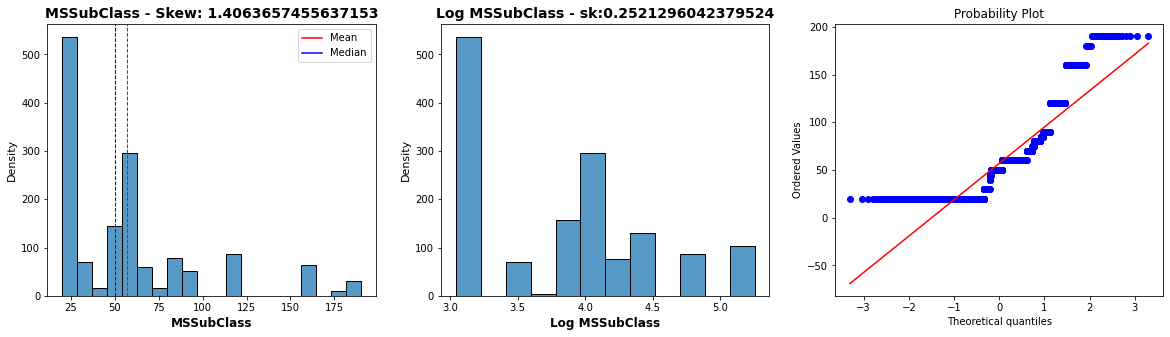

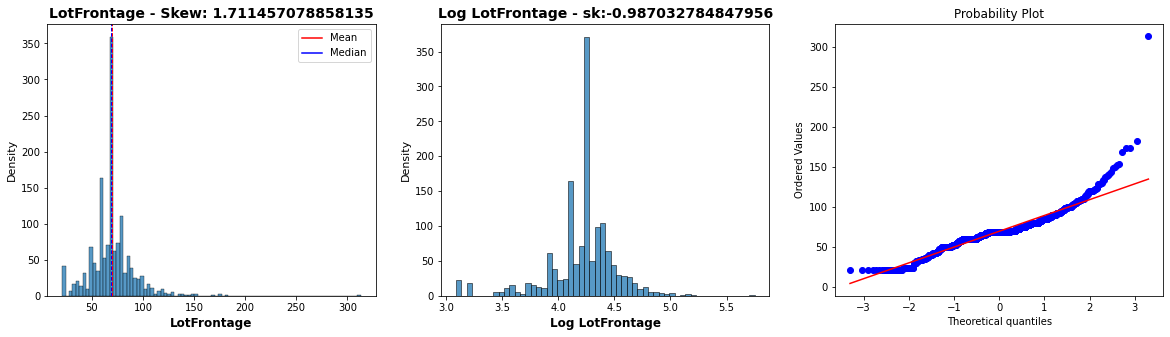

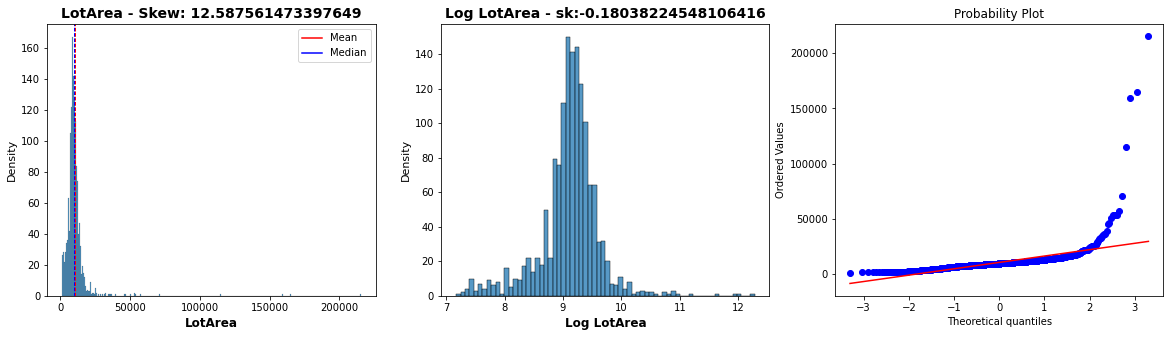

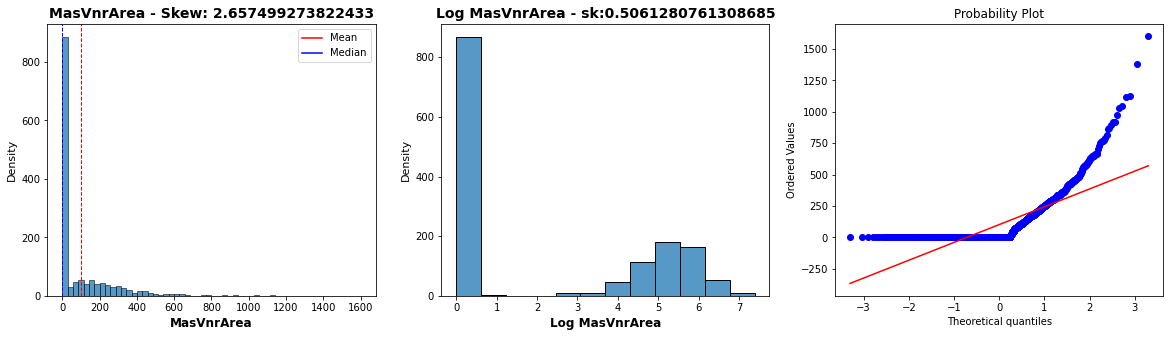

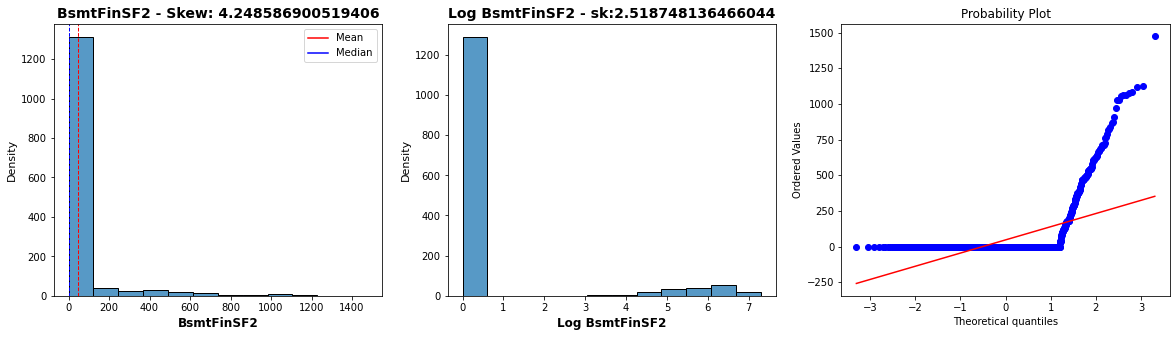

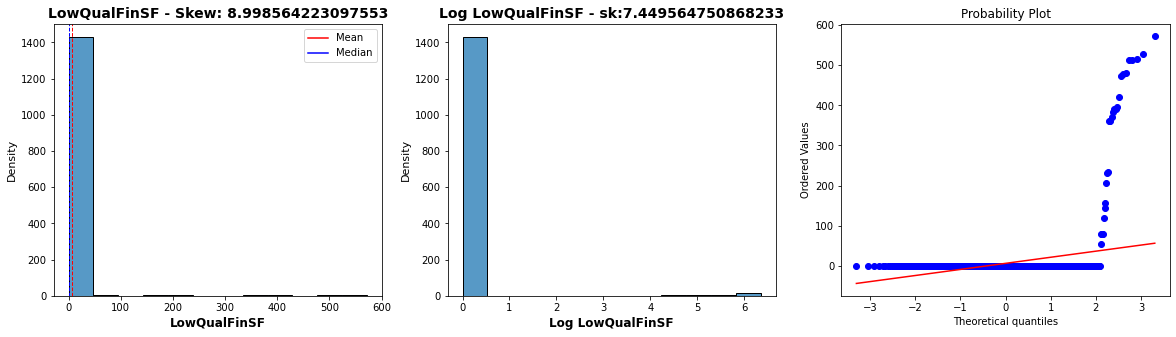

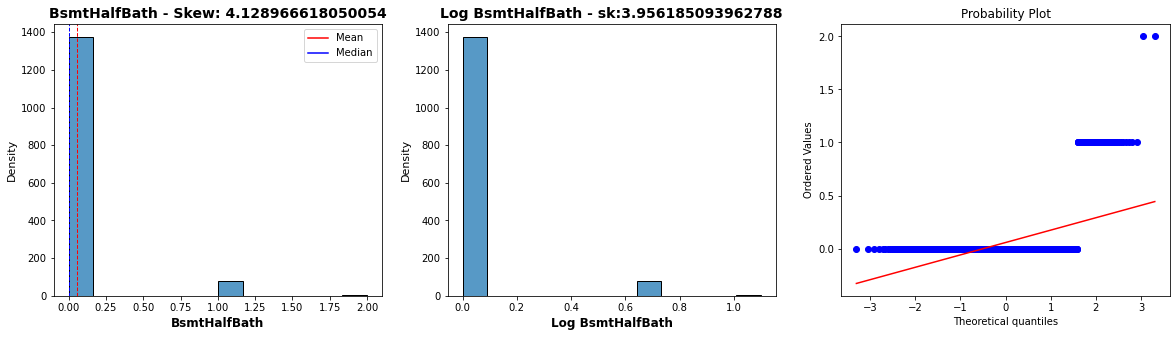

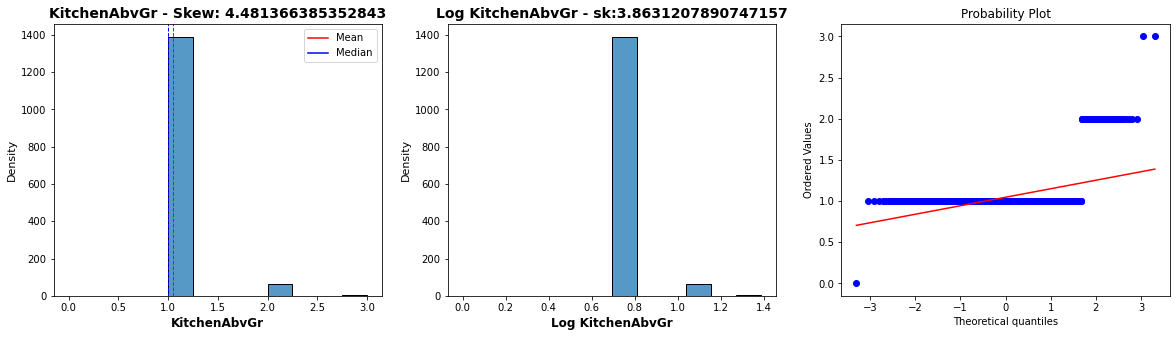

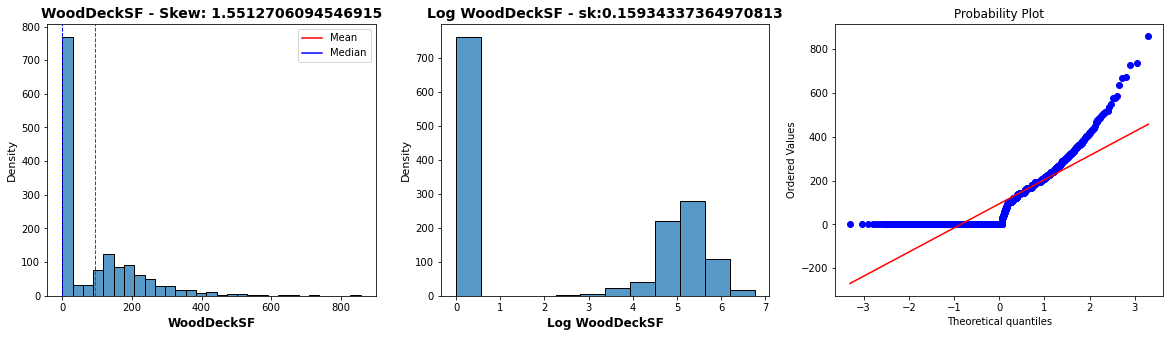

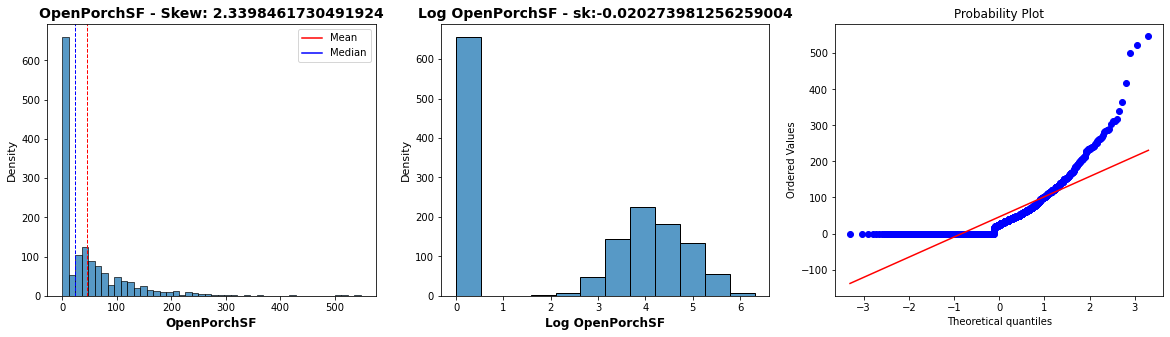

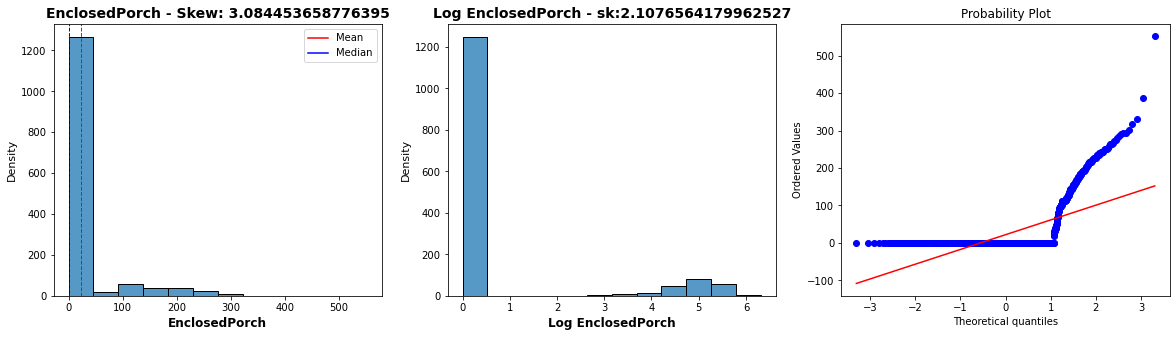

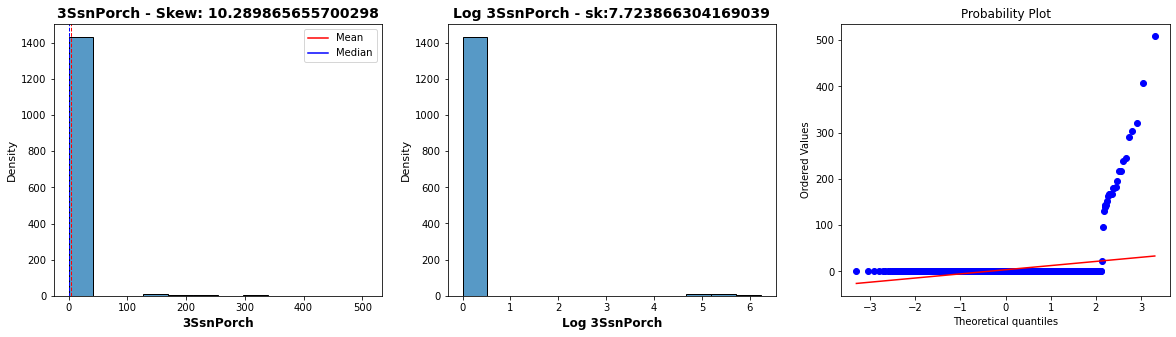

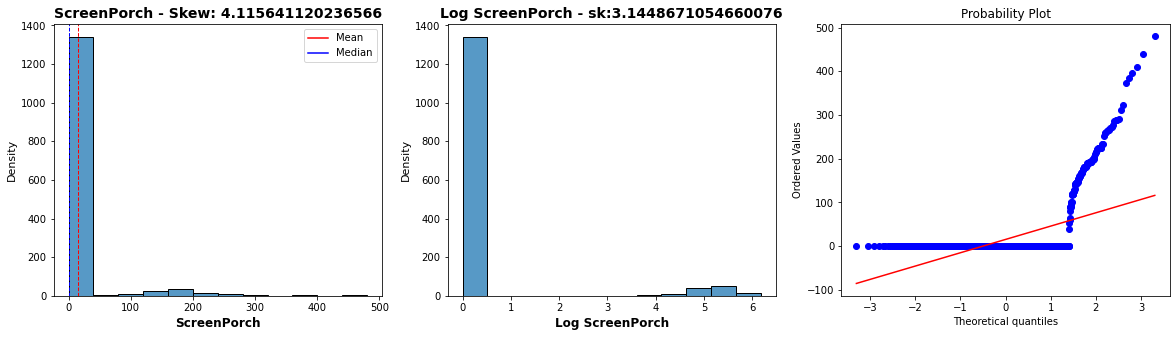

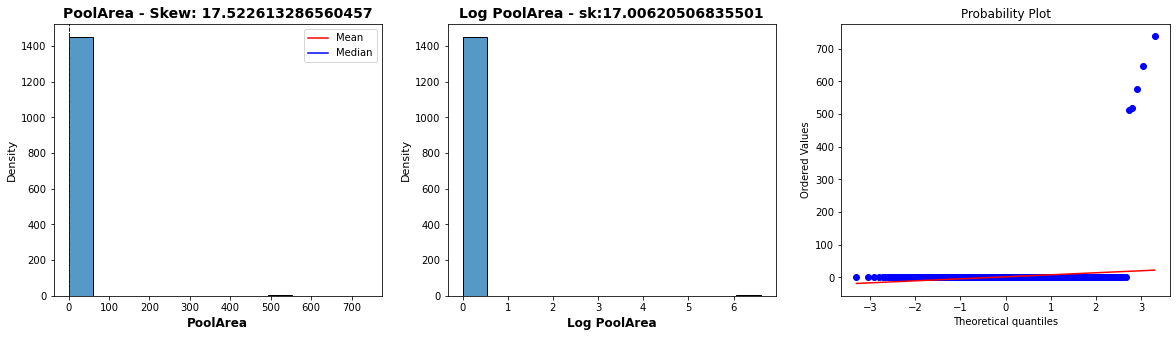

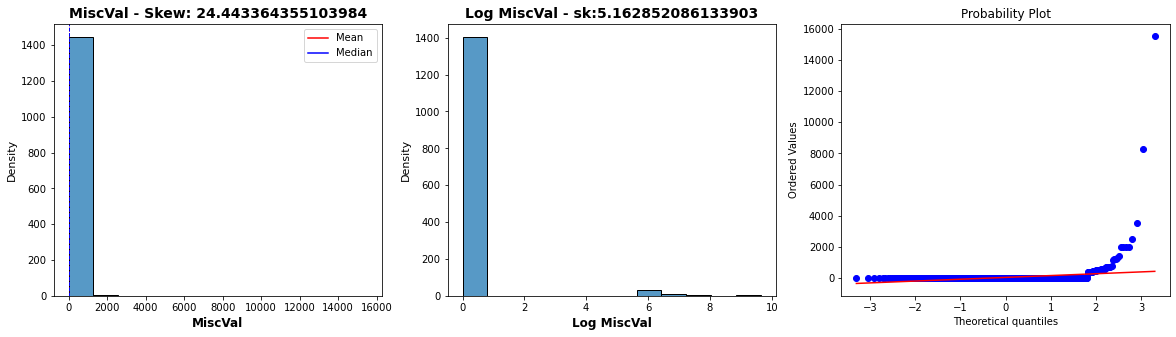

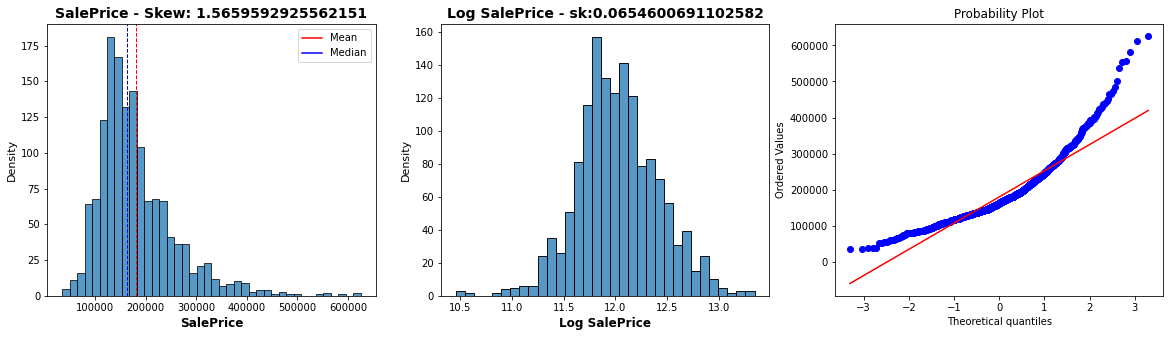

In [24]:

for col in large_skew:
    plot_compare_log(col)

After evaluating the table and graphs above, we decided to:
- We will be applying a log transformation to `LotFrontage`, `LotArea`, and `MasVnrArea`.
- Drop `PoolArea` and `MiscVal`. Only 5 houses in the sample has a pool; all other houses have a pool area of 0. The correlation plot also confirms that PoolArea is not highly correlated with Sale Price. Only 52 datapoints have miscellaneous features and this variable is also not strongly correlated with Sale Price.
- We will also be converting `MSSubClass` to a string, as it is a categorical variable with and not truly a numeric variable.

In [25]:
def feature_eng_skew(data):    
    # skewness
    skew_col= ['LotFrontage', 'LotArea', 'MasVnrArea']
    for col in skew_col:
        log_col = 'log_' + col
        data[log_col] = np.log1p(data[col])
    data = data.drop(columns=skew_col)
    
    # integer ordinal
    data['MSSubClass'] = data['MSSubClass'].astype(str)
    
    return data

In [26]:
train_df = feature_eng_skew(train_df)
test_df = feature_eng_skew(test_df)

#### 2. Introduce new variables

Some new variables that were created:
- TotalSF: Total size of the house (including basement, ground/ living area and garage) instead of having 3 separate variables
- TotalBath: Total number of baths (including full and half baths) instead of having 2 separate variables
- Binary Indicator Variables: Replace features with a binary feature that indicates whether or not the feature exists. For example, if TotalBsmtSF is greater than 0, then represent with a (1), if not represent with a (0).

In [28]:
def new_features(data):
     # combine features
    data['TotalSF'] = data['TotalBsmtSF'] + data['GrLivArea'] + data['GarageArea']
    data['TotalBath'] = data['FullBath'] + (0.5 * data['HalfBath'])
    data['YrBltAndRemod']=data['YearBuilt']+data['YearRemodAdd'] + data['GarageYrBlt']
    
    has_col = ['2ndFlrSF', 'GarageArea', 'TotalBsmtSF', 'OpenPorchSF', 'WoodDeckSF']
    for col in has_col:
        hcol = 'has_' + col
        data[hcol] = data[col].apply(lambda x: 1 if x > 0 else 0)
    data = data.drop(columns=has_col)
    
    return data

In [29]:
train_df = new_features(train_df)
test_df = new_features(test_df)

#### 3. Remove Additional Variables

Predictors with very low variance offer little predictive power to models. We will drop features with variance below 0.1.

In [31]:
# Check Variance
stats_df=pd.DataFrame()
stats_df["mean"]=train_df.mean()
stats_df["Std.Dev"]=train_df.std()
stats_df["Var"]=train_df.var()

#check if the variance is lower than 0.15
stats_df['Var < 0.1'] = np.where(stats_df['Var']< 0.1, True, False)
stats_df[stats_df['Var < 0.1'] == True]

,mean,Std.Dev,Var,Var < 0.1
BsmtHalfBath,0.057005,0.237786,0.056542,True
KitchenAbvGr,1.046703,0.220627,0.048676,True
log_LotFrontage,4.212045,0.310711,0.096542,True
has_GarageArea,0.944368,0.229288,0.052573,True
has_TotalBsmtSF,0.974588,0.157427,0.024783,True


We will drop `KitchenAbvGr` and `BsmtHalfBath`.

Next, we will drop variables with the lowest correlation with the log of saleprice, log_SalePrice.

In [32]:
abs_corr_log = train_df.corr()['log_SalePrice'].abs().sort_values(ascending=True)
print('Features with lowest correlations w/ log_Saleprice:\n', abs_corr_log.head(15))

Features with lowest correlations w/ log_Saleprice:
 BsmtFinSF2         0.006420
BsmtHalfBath       0.014974
MiscVal            0.019752
Id                 0.020511
YrSold             0.034319
OverallCond        0.036843
LowQualFinSF       0.037698
PoolArea           0.040679
3SsnPorch          0.056065
MoSold             0.062231
ScreenPorch        0.123860
has_2ndFlrSF       0.146193
KitchenAbvGr       0.147890
EnclosedPorch      0.148636
has_TotalBsmtSF    0.200758
Name: log_SalePrice, dtype: float64


- `Id` is still in the dataframe, but will be removed. The Id variable is just an identifier for each sample and has no effect on the saleprice.
- `BsmtFinSF2` will be dropped because of its low correlation with log_SalePrice. It is included also already included in TotalBsmtSF which is grouped into TotalSF. 
- `BsmtHalfBath`, `MiscVal`, `YrSold` will be dropped because its correlation is low.

Last, we will drop any remaining redundant columns.


In [33]:
# low correlation
low_corr_col = ['BsmtHalfBath', 'MiscVal', 'YrSold']

In [34]:
low_var = ['KitchenAbvGr']

In [35]:
def feature_eng(data):
    
    #drop cols
    oth_del = ['1stFlrSF', 'FullBath', 'HalfBath', 'Id', 'BsmtFinSF1', 'BsmtFinSF2', 'BsmtUnfSF', 
               'GrLivArea', 'YearBuilt', 'YearRemodAdd', 'GarageYrBlt', 'LowQualFinSF']
    
    data = data.drop(columns=low_corr_col)
    data = data.drop(columns=low_var)
    data = data.drop(columns=oth_del)
    
    return data

In [36]:
train_df = feature_eng(train_df)
test_df = feature_eng(test_df)

In [37]:
test_df.head(5)

,MSSubClass,MSZoning,Street,LotShape,LandContour,Utilities,LotConfig,LandSlope,Neighborhood,Condition1,Condition2,BldgType,HouseStyle,OverallQual,OverallCond,RoofStyle,RoofMatl,Exterior1st,Exterior2nd,MasVnrType,ExterQual,ExterCond,Foundation,BsmtQual,BsmtCond,BsmtExposure,BsmtFinType1,BsmtFinType2,Heating,HeatingQC,CentralAir,Electrical,BsmtFullBath,BedroomAbvGr,KitchenQual,TotRmsAbvGrd,Functional,Fireplaces,FireplaceQu,GarageType,GarageFinish,GarageCars,GarageQual,GarageCond,PavedDrive,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,MoSold,SaleType,SaleCondition,log_LotFrontage,log_LotArea,log_MasVnrArea,TotalSF,TotalBath,YrBltAndRemod,has_2ndFlrSF,has_GarageArea,has_TotalBsmtSF,has_OpenPorchSF,has_WoodDeckSF
0,20,RH,Pave,Reg,Lvl,AllPub,Inside,Gtl,NAmes,Feedr,Norm,1Fam,1Story,5,6,Gable,CompShg,VinylSd,VinylSd,None,TA,TA,CBlock,TA,TA,No,Rec,LwQ,GasA,TA,Y,SBrkr,0.0,2,TA,5,Typ,0,None,Attchd,Unf,1.0,TA,TA,Y,0,0,120,0,6,WD,Normal,4.394449,9.360741,0.000000,2508.0,1.0,5883.0,0,1,1,0,1
1,20,RL,Pave,IR1,Lvl,AllPub,Corner,Gtl,NAmes,Norm,Norm,1Fam,1Story,6,6,Hip,CompShg,Wd Sdng,Wd Sdng,BrkFace,TA,TA,CBlock,TA,TA,No,ALQ,Unf,GasA,TA,Y,SBrkr,0.0,3,Gd,6,Typ,0,None,Attchd,Unf,1.0,TA,TA,Y,0,0,0,0,6,WD,Normal,4.406719,9.565775,4.691348,2970.0,1.5,5874.0,0,1,1,1,1
2,60,RL,Pave,IR1,Lvl,AllPub,Inside,Gtl,Gilbert,Norm,Norm,1Fam,2Story,5,5,Gable,CompShg,VinylSd,VinylSd,None,TA,TA,PConc,Gd,TA,No,GLQ,Unf,GasA,Gd,Y,SBrkr,0.0,3,TA,6,Typ,1,TA,Attchd,Fin,2.0,TA,TA,Y,0,0,0,0,3,WD,Normal,4.317488,9.534668,0.000000,3039.0,2.5,5992.0,1,1,1,1,1
3,60,RL,Pave,IR1,Lvl,AllPub,Inside,Gtl,Gilbert,Norm,Norm,1Fam,2Story,6,6,Gable,CompShg,VinylSd,VinylSd,BrkFace,TA,TA,PConc,TA,TA,No,GLQ,Unf,GasA,Ex,Y,SBrkr,0.0,3,Gd,7,Typ,1,Gd,Attchd,Fin,2.0,TA,TA,Y,0,0,0,0,6,WD,Normal,4.369448,9.208238,3.044522,3000.0,2.5,5994.0,1,1,1,1,1
4,120,RL,Pave,IR1,HLS,AllPub,Inside,Gtl,StoneBr,Norm,Norm,TwnhsE,1Story,8,5,Gable,CompShg,HdBoard,HdBoard,None,Gd,TA,PConc,Gd,TA,No,ALQ,Unf,GasA,Ex,Y,SBrkr,0.0,2,Gd,5,Typ,0,None,Attchd,RFn,2.0,TA,TA,Y,0,0,144,0,1,WD,Normal,3.784190,8.518392,0.000000,3066.0,2.0,5976.0,0,1,1,1,0


### Label Encoding

In [38]:
train_ddf = pd.get_dummies(data=train_df, drop_first = True)
test_ddf = pd.get_dummies(data=test_df, drop_first = True)

#### Check if train and test features are the same in the dummy sets

In [39]:
# Drop `SalePrice` in train set
train_ddf = train_ddf.drop(columns='SalePrice')

train_col = train_ddf.columns
test_col = test_ddf.columns

# Which feature is in train data but not test data?
diff_feat = np.setdiff1d(train_col, test_col)
print('Feature in train data but not test data:', diff_feat, '\n')

diff_feat = np.delete(diff_feat, np.argwhere(diff_feat == 'log_SalePrice'))

test_ddf[diff_feat] = 0

diff_feat = np.setdiff1d(test_col, train_col)
print('Feature in test data but not train data:', diff_feat, '\n')

diff_feat = np.delete(diff_feat, np.argwhere(diff_feat == 'log_SalePrice'))

train_ddf[diff_feat] = 0


train_ddf = train_ddf.reindex(sorted(train_ddf.columns), axis=1)
test_ddf = test_df.reindex(sorted(test_ddf.columns), axis=1)

test_ddf.head(5)

Feature in train data but not test data: ['Condition2_RRAe' 'Condition2_RRAn' 'Condition2_RRNn' 'Electrical_Mix'
 'Exterior1st_ImStucc' 'Exterior1st_Stone' 'Exterior2nd_Other'
 'GarageQual_Fa' 'Heating_GasA' 'Heating_OthW' 'HouseStyle_2.5Fin'
 'RoofMatl_Membran' 'RoofMatl_Metal' 'RoofMatl_Roll' 'Utilities_NoSeWa'
 'log_SalePrice'] 

Feature in test data but not train data: ['MSSubClass_150'] 



,3SsnPorch,BedroomAbvGr,BldgType_2fmCon,BldgType_Duplex,BldgType_Twnhs,BldgType_TwnhsE,BsmtCond_Gd,BsmtCond_None,BsmtCond_Po,BsmtCond_TA,BsmtExposure_Gd,BsmtExposure_Mn,BsmtExposure_No,BsmtExposure_None,BsmtFinType1_BLQ,BsmtFinType1_GLQ,BsmtFinType1_LwQ,BsmtFinType1_None,BsmtFinType1_Rec,BsmtFinType1_Unf,BsmtFinType2_BLQ,BsmtFinType2_GLQ,BsmtFinType2_LwQ,BsmtFinType2_None,BsmtFinType2_Rec,BsmtFinType2_Unf,BsmtFullBath,BsmtQual_Fa,BsmtQual_Gd,BsmtQual_None,BsmtQual_TA,CentralAir_Y,Condition1_Feedr,Condition1_Norm,Condition1_PosA,Condition1_PosN,Condition1_RRAe,Condition1_RRAn,Condition1_RRNe,Condition1_RRNn,Condition2_Feedr,Condition2_Norm,Condition2_PosA,Condition2_PosN,Condition2_RRAe,Condition2_RRAn,Condition2_RRNn,Electrical_FuseF,Electrical_FuseP,Electrical_Mix,Electrical_SBrkr,EnclosedPorch,ExterCond_Fa,ExterCond_Gd,ExterCond_Po,ExterCond_TA,ExterQual_Fa,ExterQual_Gd,ExterQual_TA,Exterior1st_AsphShn,Exterior1st_BrkComm,Exterior1st_BrkFace,Exterior1st_CBlock,Exterior1st_CemntBd,Exterior1st_HdBoard,Exterior1st_ImStucc,Exterior1st_MetalSd,Exterior1st_Plywood,Exterior1st_Stone,Exterior1st_Stucco,Exterior1st_VinylSd,Exterior1st_Wd Sdng,Exterior1st_WdShing,Exterior2nd_AsphShn,Exterior2nd_Brk Cmn,Exterior2nd_BrkFace,Exterior2nd_CBlock,Exterior2nd_CmentBd,Exterior2nd_HdBoard,Exterior2nd_ImStucc,Exterior2nd_MetalSd,Exterior2nd_Other,Exterior2nd_Plywood,Exterior2nd_Stone,Exterior2nd_Stucco,Exterior2nd_VinylSd,Exterior2nd_Wd Sdng,Exterior2nd_Wd Shng,FireplaceQu_Fa,FireplaceQu_Gd,FireplaceQu_None,FireplaceQu_Po,FireplaceQu_TA,Fireplaces,Foundation_CBlock,Foundation_PConc,Foundation_Slab,Foundation_Stone,Foundation_Wood,Functional_Maj2,Functional_Min1,Functional_Min2,Functional_Mod,Functional_Sev,Functional_Typ,GarageCars,GarageCond_Fa,GarageCond_Gd,GarageCond_None,GarageCond_Po,GarageCond_TA,GarageFinish_None,GarageFinish_RFn,GarageFinish_Unf,GarageQual_Fa,GarageQual_Gd,GarageQual_None,GarageQual_Po,GarageQual_TA,GarageType_Attchd,GarageType_Basment,GarageType_BuiltIn,GarageType_CarPort,GarageType_Detchd,GarageType_None,HeatingQC_Fa,HeatingQC_Gd,HeatingQC_Po,HeatingQC_TA,Heating_GasA,Heating_GasW,Heating_Grav,Heating_OthW,Heating_Wall,HouseStyle_1.5Unf,HouseStyle_1Story,HouseStyle_2.5Fin,HouseStyle_2.5Unf,HouseStyle_2Story,HouseStyle_SFoyer,HouseStyle_SLvl,KitchenQual_Fa,KitchenQual_Gd,KitchenQual_TA,LandContour_HLS,LandContour_Low,LandContour_Lvl,LandSlope_Mod,LandSlope_Sev,LotConfig_CulDSac,LotConfig_FR2,LotConfig_FR3,LotConfig_Inside,LotShape_IR2,LotShape_IR3,LotShape_Reg,MSSubClass_150,MSSubClass_160,MSSubClass_180,MSSubClass_190,MSSubClass_20,MSSubClass_30,MSSubClass_40,MSSubClass_45,MSSubClass_50,MSSubClass_60,MSSubClass_70,MSSubClass_75,MSSubClass_80,MSSubClass_85,MSSubClass_90,MSZoning_FV,MSZoning_RH,MSZoning_RL,MSZoning_RM,MasVnrType_BrkFace,MasVnrType_None,MasVnrType_Stone,MoSold,Neighborhood_Blueste,Neighborhood_BrDale,Neighborhood_BrkSide,Neighborhood_ClearCr,Neighborhood_CollgCr,Neighborhood_Crawfor,Neighborhood_Edwards,Neighborhood_Gilbert,Neighborhood_IDOTRR,Neighborhood_MeadowV,Neighborhood_Mitchel,Neighborhood_NAmes,Neighborhood_NPkVill,Neighborhood_NWAmes,Neighborhood_NoRidge,Neighborhood_NridgHt,Neighborhood_OldTown,Neighborhood_SWISU,Neighborhood_Sawyer,Neighborhood_SawyerW,Neighborhood_Somerst,Neighborhood_StoneBr,Neighborhood_Timber,Neighborhood_Veenker,OverallCond,OverallQual,PavedDrive_P,PavedDrive_Y,PoolArea,RoofMatl_Membran,RoofMatl_Metal,RoofMatl_Roll,RoofMatl_Tar&Grv,RoofMatl_WdShake,RoofMatl_WdShngl,RoofStyle_Gable,RoofStyle_Gambrel,RoofStyle_Hip,RoofStyle_Mansard,RoofStyle_Shed,SaleCondition_AdjLand,SaleCondition_Alloca,SaleCondition_Family,SaleCondition_Normal,SaleCondition_Partial,SaleType_CWD,SaleType_Con,SaleType_ConLD,SaleType_ConLI,SaleType_ConLw,SaleType_New,SaleType_Oth,SaleType_WD,ScreenPorch,Street_Pave,TotRmsAbvGrd,TotalBath,TotalSF,Utilities_NoSeWa,YrBltAndRemod,has_2ndFlrSF,has_GarageArea,has_OpenPorchSF,has_TotalBsmtSF,has_WoodDeckSF,log_LotArea,log_LotFrontage,log_MasVnrArea
0,0,2,NaN,NaN,

## 8. Modeling

The models specified in this section do not represent all of the models that we explored as a team to preface. We focus on the models we felt were the most relevant and reasonable for brevity and efficiency.

First, import appropriate packages related to modeling use.

In [40]:
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error
from sklearn.linear_model import LinearRegression, LogisticRegression, Ridge, ElasticNet
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.tree import DecisionTreeClassifier
from xgboost import XGBRegressor

To explore the effectiveness of each model, first define the basis of how to evaluate the models. The kaggle project evaluates predictions based on root mean squared error (RMSE), so we will do the same. Below, define a function that accepts training data for dependent and independent variables, a map of parameters for use in the GridSearchCV optimization, and a model type and returns a GridSearchCV object trained on the provided data. 

In [41]:
def run_and_score_model(model, grid_search_params, X_train, y_train):
    clf = GridSearchCV(model, grid_search_params, scoring='neg_mean_squared_error')
    clf.fit(X_train, y_train)
    return clf

Next, define a function to prepare the data for inputting into the models. The function extracts the dependent variable (log of `SalePrice`) and removes the input data frame's dependent variables. Next, split the training data into training and dev data sets. The training data set will be used for hyperparameter optimization, and then the dev set will be used to compare model performance to help avoid overfitting.

In [42]:
def split_data(df):
    y_train = df['log_SalePrice'] # Target
    X_train = df.drop(['log_SalePrice'], axis = 1)
    X_train, X_dev, y_train, y_dev = train_test_split(X_train, y_train, test_size=0.2, random_state=0)
    return X_train, X_dev, y_train, y_dev

### Linear Regression

To begin the modeling process, start with a simple linear regression model. The model is appropriate because the variable we are trying to predict (log of `SalePrice`) is continuous. Multiple dependent variables should affect the value of that variable in different ways. Because the desire is not to force the linear regression through the intercept, the only hyperparameter to vary is normalizing the regressors before fitting. Other models we considered in testing: decision tree, random forest, ridge, and lass

In [43]:
params = {'fit_intercept' : [True], 'normalize' : [True, False]}

Next use the previously defined functions to fit a linear model on the cleaned training data.

In [44]:
results={}
X_train, X_dev, y_train, y_dev = split_data(train_ddf)
model = LinearRegression()
md1 = run_and_score_model(model, params, X_train, y_train)
print('Best RMSE: ', np.sqrt(-1 * md1.best_score_))
print('Best parameters: ', md1.best_params_)

Best RMSE:  21780064.573268976
Best parameters:  {'fit_intercept': True, 'normalize': False}


From the above, the best performing model on the training data has an RMSE of 21780064.57 and does not try to normalize the values. This high RMSE value reveals the model is not performing well. Next, compare the cross-validated performance on the training data to performance on dev data.

In [45]:
best_model = md1.best_estimator_
best_model.fit(X_train, y_train)
predictions = best_model.predict(X_dev)
print("RMSE Score: ", np.sqrt(mean_squared_error(y_dev, predictions)))

RMSE Score:  560299.9880269408


The RMSE of the model predictions on the dev data is lower, showing that our model is not overfitting. However, the measured value is still relatively high reflecting poor overall model performance. One feature of the data to consider is the high number of regressors. Given that there are so many terms, perhaps a combination of L1 and L2 regularization will help shrink the coefficients of less important variables down to smaller or zero values. A model that does this exceptionally well is the elastic net regression.

### Elastic Net Regression

For hyperparameter selection, there are two primary parameters to vary. First is the alpha value, a constant multiplied by the penalty terms. Second is the l1 ratio, which specifies the weighting of the l1 parameter relative to the l2 parameter. Also, specify a higher than default maximum iterations and higher than default tolerance to help models converge.

In [46]:
results={}
X_train, X_dev, y_train, y_dev = split_data(train_ddf)
params = {'alpha': [0.001, 0.01, 0.1, 0.5, 1.0, 2.0, 10.0, 20.0], 
          'l1_ratio' : [0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8,0.9,1],
          'max_iter' : [10000],
          'tol' : [.1]
         }
model = ElasticNet()
md2 = run_and_score_model(model, params, X_train, y_train)
print('Best RMSE: ', np.sqrt(-1 * md2.best_score_))
print('Best parameters: ', md2.best_params_)

/Users/jeffday/opt/anaconda3/envs/207_final_project/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 13.838081755331144, tolerance: 13.800390957311826
  model = cd_fast.enet_coordinate_descent(
/Users/jeffday/opt/anaconda3/envs/207_final_project/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 14.185637829399301, tolerance: 13.800390957311826
  model = cd_fast.enet_coordinate_descent(


Best RMSE:  0.12427827642228069
Best parameters:  {'alpha': 0.001, 'l1_ratio': 0.9, 'max_iter': 10000, 'tol': 0.1}


The above RMSE value is much better than the basic linear regression, reiterating that flexibility to the coefficients' weighting improves model performance. The optimization of the model chose an alpha value of 0.001 and an l1 ratio of 0.9. Next, examine performance on the dev data.

In [47]:
best_model = md2.best_estimator_
best_model.fit(X_train, y_train)
predictions = best_model.predict(X_dev)
print("RMSE Score: ", np.sqrt(mean_squared_error(y_dev, predictions)))

RMSE Score:  0.11230701377485881


The RMSE of the dev data model is better than the training data, reiterating that the model is not overfitting. The second model iteration solved an issue with using many regressors. However, it is possible to get a better signal out of less critical features using ensemble models. To see if we can improve model performance any further, try utilizing an ensemble model like gradient boosting. 

### Gradient Boosting
One implication of having many different regressors is that many of them can be relatively weak learners. To try and get some more predictive power out of the weak learners, use gradient boosting to help turn them into strong learners. Gradient boost is also appropriate because it performs well on data sets with a mixture of categorical and numerical variables like in the housing data set.

There are many more hyperparameters to experiment with the XGBRegressor. First is max depth, which defines the max depth of a tree used in the regression and can help avoid overfitting. Next is subsample, which denotes the fraction of samples used in building each tree. Next is the learning rate, which varies the weights in each subsequent step on the model ensemble building. Finally like with our second model, try varying the alpha parameter to avoid overfitting.

In [48]:
results={}
params = {
    'max_depth' : [5, 6, 7],
    'subsample' : [0.5, 0.75, 1.0],
    'learning_rate': [0.01, 0.1, 0.5],
    'reg_alpha':[1e-5, 1e-2, 0.1, 1, 100],
    'min_child_weight':[4,5,6]
}
X_train, X_dev, y_train, y_dev = split_data(train_ddf)
model = XGBRegressor()
md3 = run_and_score_model(model, params, X_train, y_train)
print('Best RMSE: ', np.sqrt(-1 * md3.best_score_))
print('Best parameters: ', md3.best_params_)

Best RMSE:  0.12534633047569727
Best parameters:  {'learning_rate': 0.1, 'max_depth': 6, 'min_child_weight': 6, 'reg_alpha': 1e-05, 'subsample': 0.75}


Gradient boosting model gives similar RMSE on training data. Next, examine performance on dev data.

In [49]:
best_model = md3.best_estimator_
best_model.fit(X_train, y_train)
predictions = best_model.predict(X_dev)
print("RMSE Score: ", np.sqrt(mean_squared_error(y_dev, predictions)))

RMSE Score:  0.11249919792996486


Both the dev and train data performance of the gradient boost regression model is not significantly better that the elastic net regression. This implies that perhaps more refinement of regressors is needed, or that the models may need to be combined to improve performance.

Finally, use the below function for creating submission files to Kaggle.

In [ ]:
def create_prediction_csv(model, df):
    '''Create Submission File for Kaggle'''
    
    submission_test_df = df
    y_pred = model.predict(submission_test_df)
    submission = pd.DataFrame({
            'Id': test_ids,
            'SalePrice': np.round(np.exp(y_pred), decimals=2)
        })
    submission.to_csv('submission.csv', index=False)

The elastic net model's test score was 0.13665, and the test score for the gradient boosting model was 0.13333. Considering all three scores from train, dev, and test, the gradient boosting and elastic net models have relatively similar performance, and the elastic net is overall simpler and faster.